In [78]:
!pip install scanpy
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np
import warnings

sc.settings.set_figure_params(dpi=80)
warnings.filterwarnings('ignore')

  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Mapping mitochondira genes

In [80]:
genelist = pd.read_csv('/content/kannan et al mitomap.txt', sep="\t")
genelist.reset_index(inplace = True)
genelist.columns = ['mitogene','othernames']
genelist.head()
# many replicate

,mitogene,othernames
0,mt-Td,mt-Td
1,mt-Tr,mt-Tr
2,mt-Tf,mt-Tf
3,mt-Tp,mt-Tp
4,mt-Tk,mt-Tk


In [81]:
genelist = genelist[genelist['mitogene']!=genelist['othernames']]
genelist.reset_index(drop=True,inplace=True)
for i in range(len(genelist)):
  map_name = genelist['othernames'][i].split(';')
  genelist['othernames'][i] = map_name
genelist

,mitogene,othernames
0,mt-Nd6,"[mt-Nd6, Gm11408]"
1,mt-Atp8,"[Gm10925, mt-Atp8, mt-Atp6]"
2,mt-Co1,"[Gm29216, Gm13340, mt-Co1, Gm11512]"
3,mt-Nd5,"[Gm4076, Gm11407, mt-Nd5]"
4,mt-Nd3,"[Gm28438, mt-Nd3]"
5,mt-Nd2,"[Gm48122, mt-Nd2, Gm13339]"
6,mt-Atp6,"[Gm10925, mt-Atp8, AC124578.3, mt-Atp6, Gm4374..."
7,mt-Cytb,"[Gm11410, mt-Cytb]"
8,mt-Ty,"[Cep295, mt-Ty]"
9,mt-Nd4l,"[Gm10222, mt-Nd4l]"


In [82]:
map_dict = genelist.set_index("mitogene")["othernames"].to_dict()
print(map_dict)

{'mt-Nd6': ['mt-Nd6', 'Gm11408'], 'mt-Atp8': ['Gm10925', 'mt-Atp8', 'mt-Atp6'], 'mt-Co1': ['Gm29216', 'Gm13340', 'mt-Co1', 'Gm11512'], 'mt-Nd5': ['Gm4076', 'Gm11407', 'mt-Nd5'], 'mt-Nd3': ['Gm28438', 'mt-Nd3'], 'mt-Nd2': ['Gm48122', 'mt-Nd2', 'Gm13339'], 'mt-Atp6': ['Gm10925', 'mt-Atp8', 'AC124578.3', 'mt-Atp6', 'Gm43743', 'Gm43743'], 'mt-Cytb': ['Gm11410', 'mt-Cytb'], 'mt-Ty': ['Cep295', 'mt-Ty'], 'mt-Nd4l': ['Gm10222', 'mt-Nd4l'], 'mt-Co3': ['Gm28927', 'Gm28437', 'mt-Co3', 'AC125122.2'], 'mt-Co2': ['Gm28661', 'Gm13341', 'Gm12155', 'mt-Co2'], 'mt-Rnr2': ['Gm20594', 'mt-Rnr2'], 'mt-Nd4': ['Gm28439', 'mt-Nd4']}


In [83]:
def get_keys(value):
    return [k for k,v in map_dict.items() if value in v]

In [84]:
get_keys('Gm20594')

['mt-Rnr2']

In [85]:
# read data
adata = sc.read_h5ad("/content/drive/MyDrive/CSCB/cardiac_cells_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 215 × 19424
    obs: 'batch', 'cardiac muscle cell', 'endocardial cell', 'endothelial cell', 'fibroblast', 'leukocyte', 'myofibroblast cell', 'rand', 'smooth muscle cell', 'SCN_class'
    layers: 'raw_count'

In [86]:
# cell filtration are necessary
# removed all ribosomal protein-coding genes prior to computation of entropy
#mito_genes = adata.var_names.str.startswith('mt-')
ribo_genes = adata.var_names.str.startswith(("Rpl","Rps"))
malat_gene = adata.var_names.str.startswith("Malat1")

remove = np.add(ribo_genes, malat_gene)

keep = np.invert(remove)

adata = adata[:,keep]#.copy()
adata.X.shape

(215, 19327)

In [87]:
# convert to dataframe
Exp_matrix = pd.DataFrame(adata.layers['raw_count']).T
Exp_matrix.index = adata.var_names
Exp_matrix.reset_index(inplace=True)
Exp_matrix

,index,0,1,2,3,4,5,6,7,8,...,205,206,207,208,209,210,211,212,213,214
0,0610009B22Rik,2.0,0.0,2.0,2.0,1.0,3.0,0.0,2.0,0.0,...,6.0,2.0,0.0,1.0,3.0,2.0,0.0,2.0,2.0,0.0
1,0610009L18Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0610010K14Rik,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0610030E20Rik,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0610038B21Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19322,Zyg11b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19323,Zyx,3.0,2.0,2.0,3.0,4.0,4.0,1.0,4.0,3.0,...,7.0,0.0,0.0,2.0,0.0,5.0,0.0,2.0,3.0,2.0
19324,Zzef1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
19325,Zzz3,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [88]:
for i in range(len(Exp_matrix)):
  name = Exp_matrix['index'][i]
  if len(get_keys(name)):
    Exp_matrix['index'][i] = get_keys(name)[0]
    print("complete a replacement on index",i,"from",name,"to",Exp_matrix['index'][i])

complete a replacement on index 6553 from Gm20594 to mt-Rnr2


In [89]:
Exp_matrix = Exp_matrix.groupby(['index']).sum().T

In [90]:
# read reference data
adaref = sc.read_h5ad("/content/drive/MyDrive/CSCB/Kannan_perinatal_reference.h5ad")
adaref

AnnData object with n_obs × n_vars = 936 × 29593
    obs: 'i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads'

In [91]:
# QC filter
#mito_genes = adaref.var_names.str.startswith('mt-')
ribo_genes = adaref.var_names.str.startswith(("Rpl","Rps"))
malat_gene = adaref.var_names.str.startswith("Malat1")

remove = np.add(ribo_genes, malat_gene)

keep = np.invert(remove)

adaref = adaref[:,keep]#.copy()
adaref.X.T.shape

(29251, 936)

In [92]:
Exp_matrix_ref = pd.DataFrame(adaref.X).T
Exp_matrix_ref.index = adaref.var_names
Exp_matrix_ref.reset_index(inplace=True)
Exp_matrix_ref

,index,0,1,2,3,4,5,6,7,8,...,926,927,928,929,930,931,932,933,934,935
0,Gnai3,0.0,0.0,1.0,0.0,4.0,0.0,3.0,1.0,0.0,...,0.0,0.0,9.0,0.0,20.0,3.0,1.0,0.0,8.0,0.0
1,Pbsn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cdc45,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
3,H19,59.0,267.0,20.0,50.0,490.0,24.0,13.0,51.0,254.0,...,54.0,4.0,424.0,173.0,2502.0,984.0,1225.0,33.0,77.0,129.0
4,Scml2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29246,5730414N17Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29247,Gm49463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29248,Gm49494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29249,4930414F18Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
for i in range(len(Exp_matrix_ref)):
  name = Exp_matrix_ref['index'][i]
  if len(get_keys(name)):
    Exp_matrix_ref['index'][i] = get_keys(name)[0]
    print("complete a replacement on index",i,"from",name,"to",Exp_matrix_ref['index'][i])

complete a replacement on index 12511 from Cep295 to mt-Ty
complete a replacement on index 15734 from mt-Rnr2 to mt-Rnr2
complete a replacement on index 15739 from mt-Nd2 to mt-Nd2
complete a replacement on index 15743 from mt-Co1 to mt-Co1
complete a replacement on index 15745 from mt-Co2 to mt-Co2
complete a replacement on index 15746 from mt-Atp8 to mt-Atp8
complete a replacement on index 15747 from mt-Atp6 to mt-Atp8
complete a replacement on index 15748 from mt-Nd3 to mt-Nd3
complete a replacement on index 15752 from mt-Nd5 to mt-Nd5
complete a replacement on index 15753 from mt-Nd6 to mt-Nd6
complete a replacement on index 15755 from mt-Cytb to mt-Cytb
complete a replacement on index 15850 from mt-Nd4l to mt-Nd4l
complete a replacement on index 18521 from Gm11407 to mt-Nd5
complete a replacement on index 18759 from Gm12155 to mt-Co2
complete a replacement on index 18797 from Gm13339 to mt-Nd2
complete a replacement on index 18870 from Gm11408 to mt-Nd6
complete a replacement on i

In [94]:
Exp_matrix_ref = Exp_matrix_ref.groupby(['index']).sum().T
Exp_matrix_ref

index,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,n-R5s2,n-R5s216,n-R5s25,n-R5s29,n-R5s39,n-R5s54,n-R5s58,n-R5s73,n-R5s85,n-R5s97
0,0.0,0.0,0.0,0.0,1.0,18.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,3.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,3.0,0.0,20.0,0.0,0.0,51.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,8.0,0.0,0.0,0.0,12.0,1.0,0.0,18.0,0.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
932,0.0,0.0,2.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
934,0.0,0.0,0.0,0.0,1.0,9.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Differential gene expression for Kannan's reference CM cells

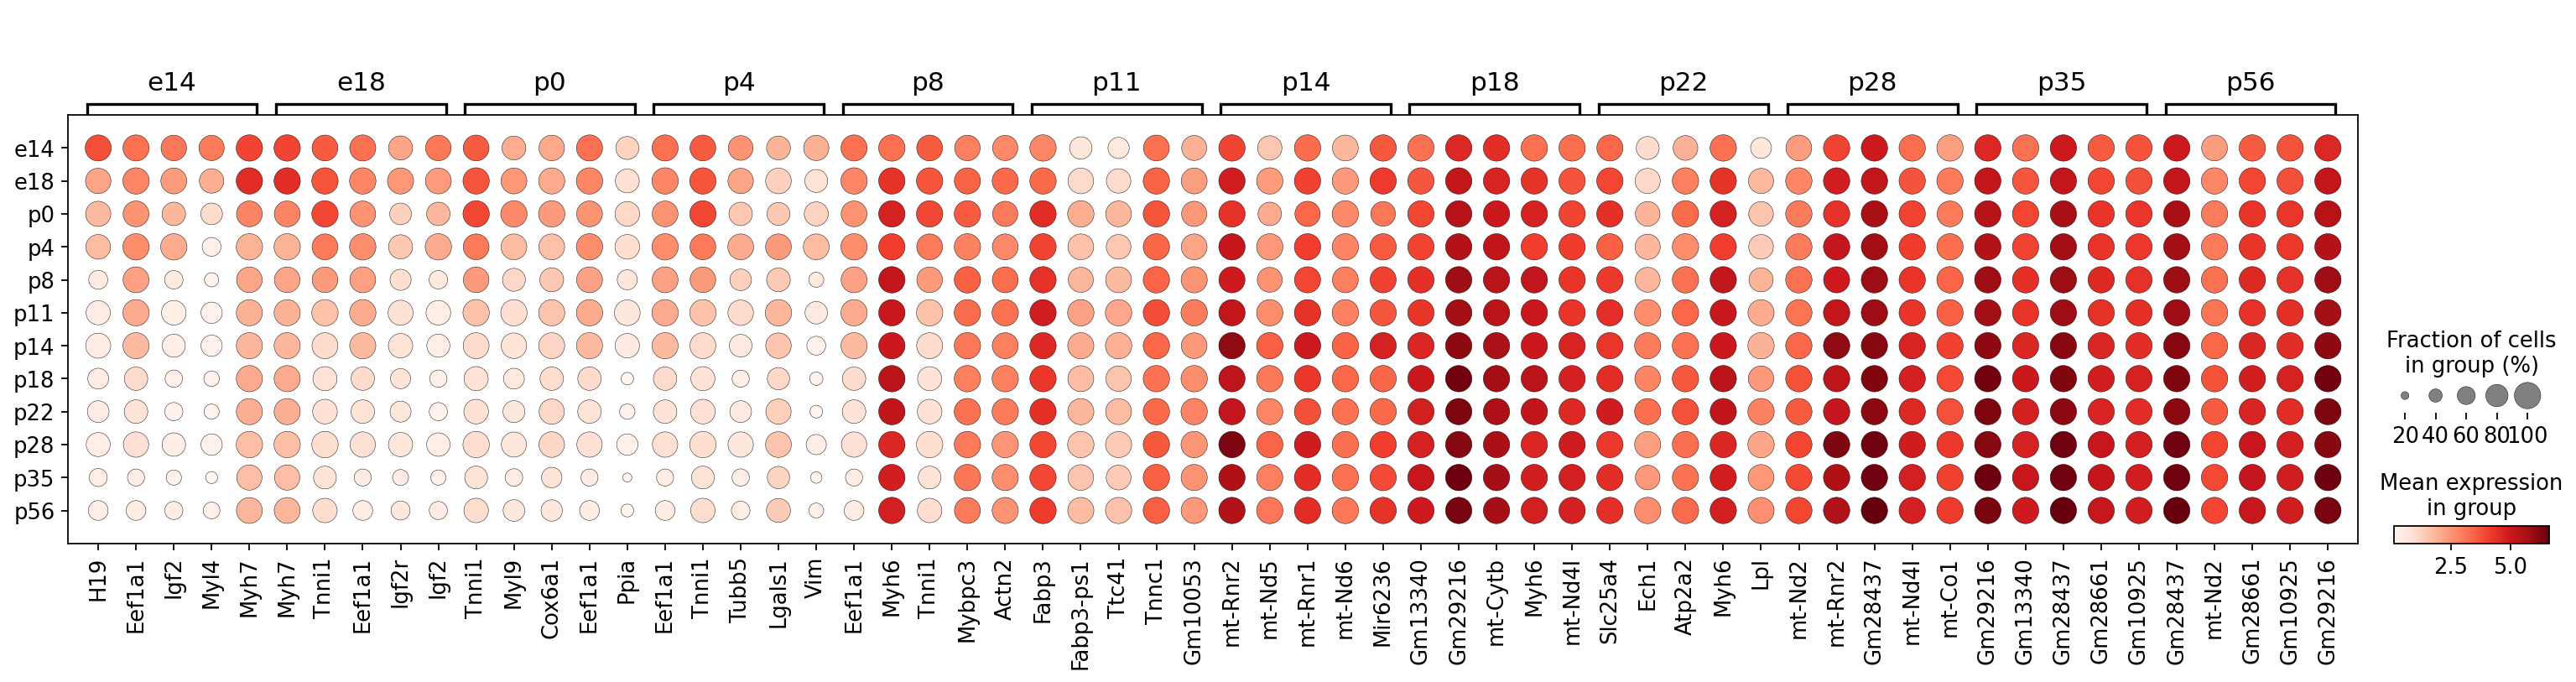

In [95]:
adM1Norm = adaref.copy()
sc.pp.filter_genes(adM1Norm, min_cells=5)
sc.pp.normalize_per_cell(adM1Norm, counts_per_cell_after=1e4)
sc.pp.log1p(adM1Norm)
sc.pp.highly_variable_genes(adM1Norm, min_mean=0.0125, max_mean=5, min_disp=0.25)

sc.tl.rank_genes_groups(adM1Norm, 'timepoint')
sc.pl.rank_genes_groups_dotplot(adM1Norm, n_genes=5, groupby='timepoint', use_raw=False, dendrogram=False)

## Differential gene expression for Kannan's reference CM cells with mito genes removed

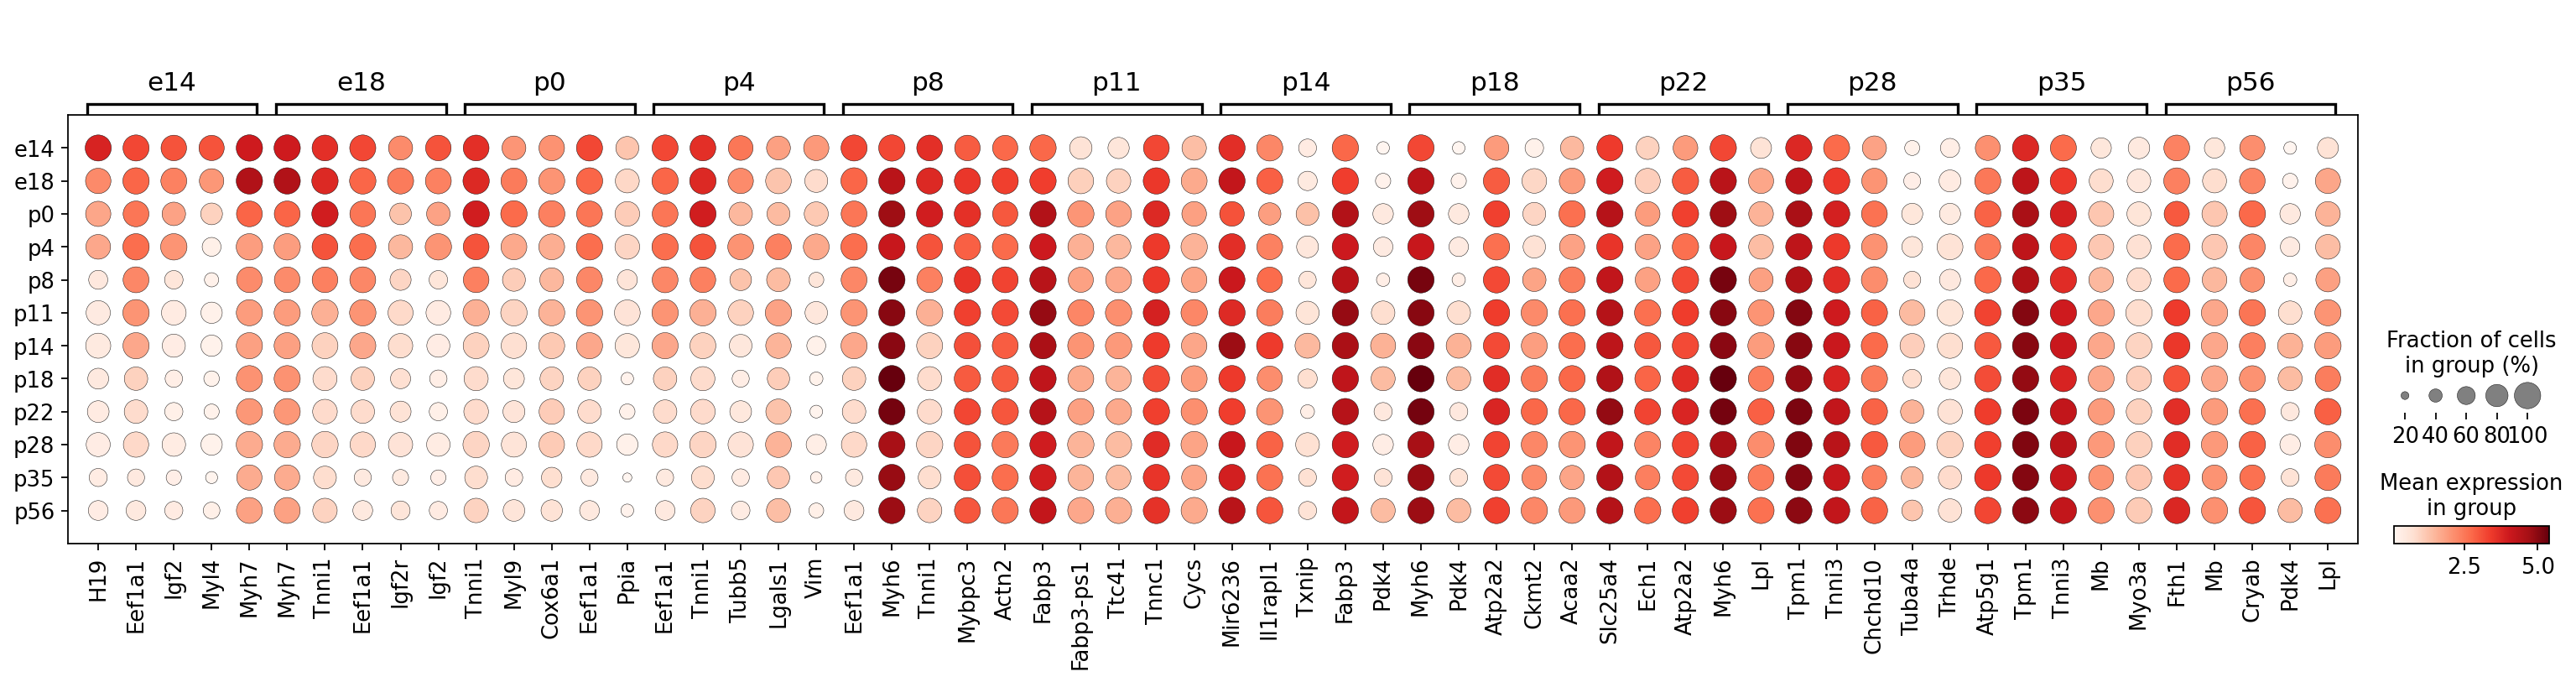

In [96]:
mito_genes = adM1Norm.var_names.str.startswith(('mt-','Gm'))
keep = np.invert(mito_genes)
adM1Norm = adM1Norm[:,keep]

sc.tl.rank_genes_groups(adM1Norm, 'timepoint')
sc.pl.rank_genes_groups_dotplot(adM1Norm, n_genes=5, groupby='timepoint', use_raw=False, dendrogram=False)

In [97]:
timepoint = pd.DataFrame(adaref.obs['timepoint'])

## Calculate entropy Shannon value for the Kannan's reference CM cells

In [98]:
def calculate_entropy(X):
    # initialize prob
    P = np.zeros(len(X))
    sum = np.sum(X)
    for i in range(len(X)):
        # number of i
        P[i]=X[i]/sum
    # Entropy score can be caculated by -∑(PlogP)
    entropy = np.sum([-p*math.log(p,2) for p in P[P>0]])

    return entropy

In [99]:
# Entropy score in CMs taken from reference datasets.
entropy = []
for i in range(len(Exp_matrix_ref)):
    array = Exp_matrix_ref.iloc[i].to_numpy()
    entropy.append(calculate_entropy(array))

In [100]:
entropy_score = pd.DataFrame(entropy)
entropy_score.columns = ['entropy']
entropy_score.index = timepoint.index
result = pd.concat([timepoint,entropy_score], axis=1)
result

,timepoint,entropy
AAGAGGCAAAAGTT,e18,10.079381
AAGAGGCAATATAG,e14,10.961359
AAGAGGCAATCAAA,e18,10.160393
AAGAGGCAATGAAT,p0,10.427813
AAGAGGCACCCACG,e14,10.797570
...,...,...
GGACTCCTTCTGCA,p4,11.404932
GTAGAGGAAAGATT,p4,10.916225
TAGGCATGTTGAAA,p8,10.158344
TCCTGAGCCCAACC,p8,10.017412


In [101]:
#python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


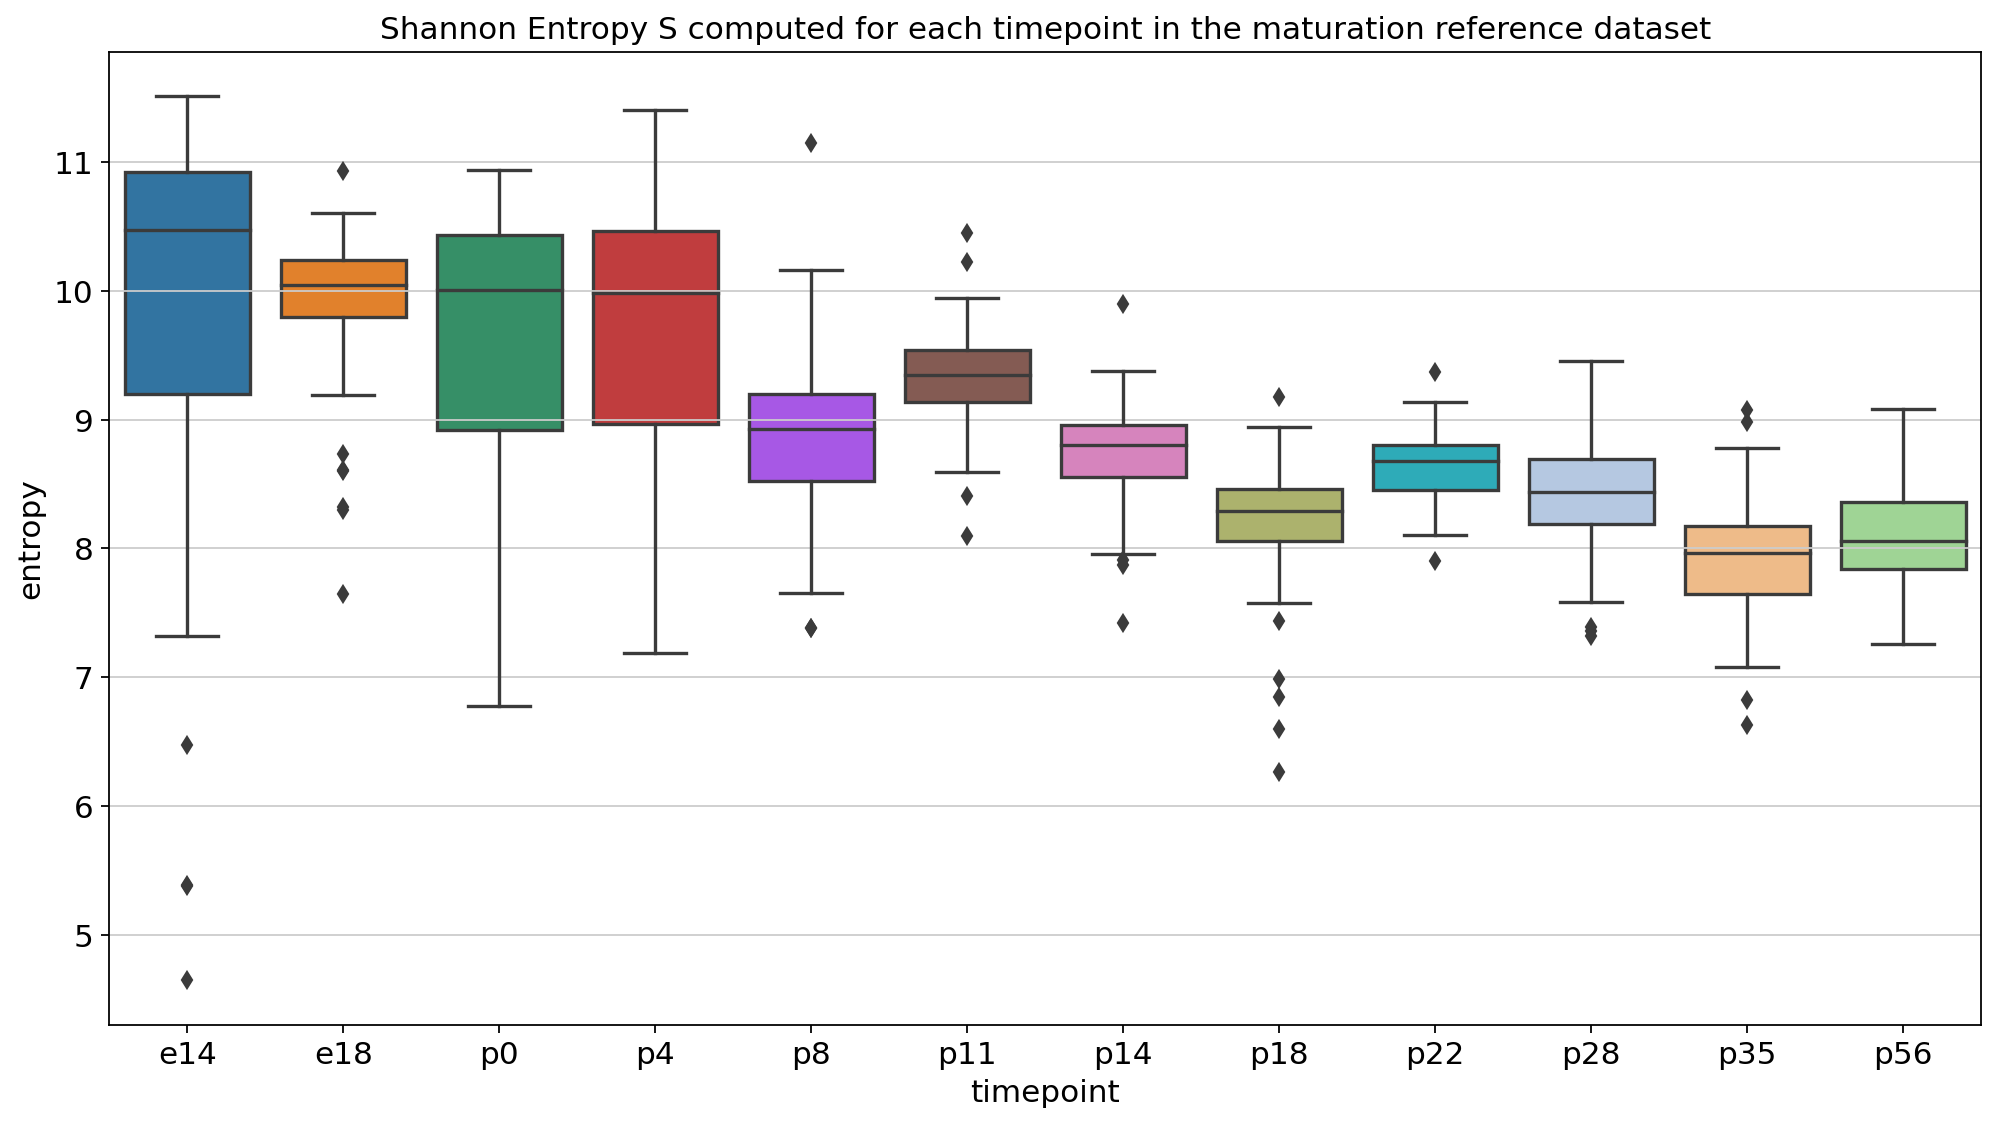

In [102]:
plt.figure(figsize=(15, 8))
myfig = plt.gcf()
sns.boxplot(x="timepoint", y="entropy", data=result)
plt.title("Shannon Entropy S computed for each timepoint in the maturation reference dataset")
plt.show()
myfig.savefig('boxplot.png')

In [103]:
# Shannon entropy of single cell gene expression decreases over CM maturation
# In this model, nascent cardiomyocytes express a broad gene expression profile. 
# However, as they mature, they slowly reduce expression of immature gene pathways (e.g. cell cycle) 
# while upregulating genes required for mature function (e.g. sarcomere, calcium handling, oxidative phosphorylation). 
# These gradual changes in gene distribution can be quantified by established diversity metrics such as the well-known Shannon entropy. 
# In our model, immature myocytes will present with high transcriptomic entropy, 
# which subsequently decreases in a continuous manner over the course of maturation.
# The scores are consistent across datasets regardless of potentially confounding batch effects.
# Therefore, we can apply it in our dataset.

## Calculate entropy value for Stone's CM cells

In [104]:
# Since we are 1000% percent convinced that your dataset has been 
# appropriately filted for CMs and only high quality cells, we 
# directly caculate Shannon entropy 

entropy = []
for i in range(len(Exp_matrix)):
    array = Exp_matrix.iloc[i].to_numpy()
    entropy.append(calculate_entropy(array))

In [105]:
# average entropy value of every timepoint for reference CM cells
entropy_avg = []
corresponding_time = []
for time in pd.unique(result['timepoint']):
  time_result = result[result['timepoint']==time]
  avg = np.mean(time_result['entropy'])
  entropy_avg.append(avg)
  corresponding_time.append(time)

In [106]:
data = {'time':corresponding_time,'entropy':entropy_avg}
df = pd.DataFrame(data=data)
df.sort_values(by=['entropy'], ascending=False)

,time,entropy
0,e18,9.923626
1,e14,9.872023
3,p4,9.720622
2,p0,9.627776
10,p11,9.339910
11,p8,8.880318
4,p14,8.752926
5,p22,8.643683
6,p28,8.411208
9,p18,8.199984


In [107]:
df.index = df['time'].values
df = df.reindex(index = ['e14','e18','p0','p4','p8','p11','p14','p18','p22','p28','p35','p56'])
df['x']=range(12)
df

,time,entropy,x
e14,e14,9.872023,0
e18,e18,9.923626,1
p0,p0,9.627776,2
p4,p4,9.720622,3
p8,p8,8.880318,4
p11,p11,9.339910,5
p14,p14,8.752926,6
p18,p18,8.199984,7
p22,p22,8.643683,8
p28,p28,8.411208,9


In [108]:
# result.index = result['timepoint'].values
# map_dict={'e14':0,'e18':1,'p0':2,'p4':3,'p8':4,'p11':5,'p14':6,'p18':7,'p22':8,'p28':9,'p35':10,'p56':11}
# result['state'] = result['timepoint'].apply(lambda x : map_dict[x])
# result

In [109]:
X = df['x'].values.reshape(-1, 1)
y = df['entropy'].values

In [110]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(X, y)
clf.coef_
clf.score(X, y)

0.8863625765347443

In [111]:
array = np.arange(12).reshape(-1, 1)
bins = clf.predict(array)
bins

array([9.99150897, 9.80171505, 9.61192113, 9.42212721, 9.23233329,
       9.04253937, 8.85274545, 8.66295153, 8.47315761, 8.28336369,
       8.09356977, 7.90377585])

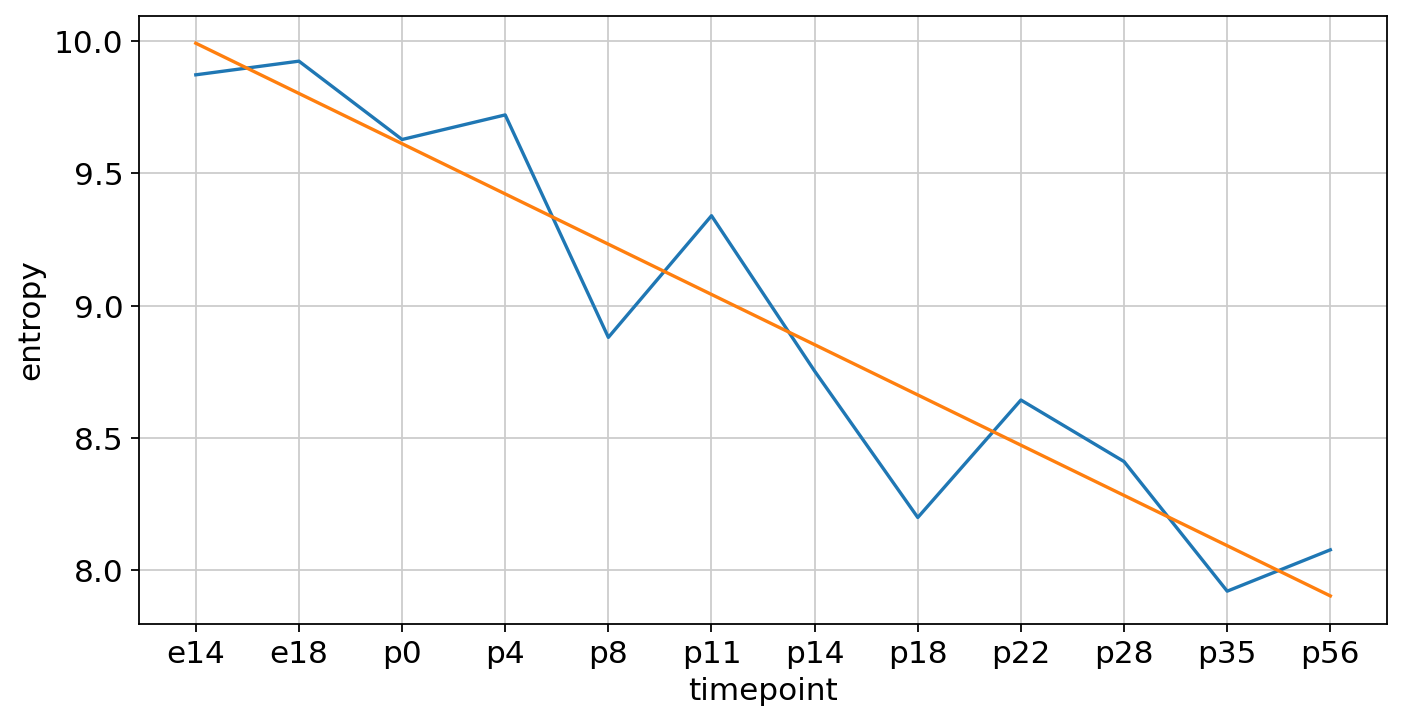

In [112]:
X = df['time'].values
plt.figure(figsize=(10, 5))
plt.plot(X,y)
plt.plot(X,bins)
plt.xlabel("timepoint")
plt.ylabel("entropy")
plt.show()

Entropy vs timpoint for Kannan's reference data

In [113]:
entropy = np.array(entropy)
inds = np.digitize(entropy, bins)
inds[inds==12]=11
inds

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  0,  1,  0,  0,  0,
        0,  3,  0,  0,  2,  0,  0,  3,  1,  0,  0,  0,  0,  1,  3,  0,  0,
        1,  0,  1, 11,  0,  0,  0,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 10,  1,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        4,  1,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,
        0,  0,  0,  0,  3,  0,  0,  1,  1,  3,  0,  2,  0,  0,  1,  1,  0,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  3,  0,  0,  0,  0,
        0,  2,  0,  0,  0,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,
        0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  6,  0,  2,  0,  0,
        0,  0,  0,  0,  1,  0,  1,  3,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  3,  3,  0,  1,  0,  1,  1,  0,  0,  0,  2,  0,
        0,  1,  0,  0,  1,  0,  0,  0,  0,  2,  0])

In [114]:
batch = pd.DataFrame(adata.obs['batch'])
batch.reset_index(drop=True,inplace=True)
data_state = pd.concat([batch,pd.DataFrame(inds)],axis=1)
data_state.columns = ['batch','timepoint']
data_state

,batch,timepoint
0,6,0
1,4,0
2,6,0
3,6,0
4,6,0
...,...,...
210,6,0
211,6,0
212,6,0
213,6,2


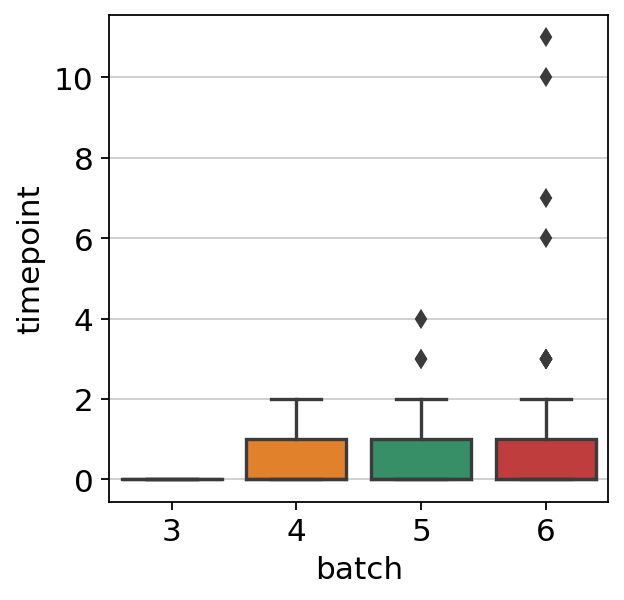

In [115]:
myfig = plt.gcf()
sns.boxplot(x="batch", y="timepoint", data=data_state)
myfig.savefig("batch")

Cell state vs batches of cells for Stone's CM cells.

### **Option 2**

In [116]:
adata_human = sc.read_h5ad("/content/drive/MyDrive/CSCB/human_cardiac_cells_raw.h5ad")
adata_human

AnnData object with n_obs × n_vars = 116 × 14618
    obs: 'cardiac muscle cell', 'endocardial cell', 'endothelial cell', 'fibroblast', 'leukocyte', 'myofibroblast cell', 'rand', 'smooth muscle cell', 'SCN_class'
    var: 'gene_ids'
    layers: 'raw_count'

In [117]:
ribo_genes = adata_human.var_names.str.startswith(("Rpl","Rps"))
malat_gene = adata_human.var_names.str.startswith("Malat1")

remove = np.add(ribo_genes, malat_gene)

keep = np.invert(remove)

adata_human = adata_human[:,keep]#.copy()
adata_human.X.shape

(116, 14532)

In [118]:
adata_human.X.todense().shape

(116, 14532)

In [119]:
# mito-correction
# convert to dataframe
exp_matrix = pd.DataFrame(adata_human.X.todense()).T
exp_matrix.index = adata_human.var_names
exp_matrix.reset_index(inplace=True)
exp_matrix

,index,0,1,2,3,4,5,6,7,8,...,106,107,108,109,110,111,112,113,114,115
0,0610010F05Rik,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0610010K14Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0610030E20Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0610037L13Rik,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0610040J01Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14527,Zyg11b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14528,Zyx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14529,Zzef1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14530,Zzz3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
for i in range(len(exp_matrix)):
  name = exp_matrix['index'][i]
  if len(get_keys(name)):
    exp_matrix['index'][i] = get_keys(name)[0]
    print("complete a replacement on index",i,"from",name,"to",exp_matrix['index'][i])

complete a replacement on index 4972 from Gm20594 to mt-Rnr2


In [121]:
exp_matrix = exp_matrix.groupby(['index']).sum().T

In [122]:
entropy = []
for i in range(len(exp_matrix)):
    array = exp_matrix.iloc[i].to_numpy()
    entropy.append(calculate_entropy(array))

In [123]:
entropy = np.array(entropy)
inds = np.digitize(entropy, bins)
inds = inds-1

In [124]:
X = df['time'].values

In [125]:
num_list = []
i_list = []
for i in pd.unique(inds):
  num = np.sum(inds==i)
  num_list.append(num)
  i_list.append(i)

In [126]:
map_dict={'e14':0,'e18':1,'p0':2,'p4':3,'p8':4,'p11':5,'p14':6,'p18':7,'p22':8,'p28':9,'p35':10,'p56':11}
map_dict = {v: k for k, v in map_dict.items()}

In [132]:
result = pd.DataFrame({'timepoint':i_list,'number':num_list})
result['timepoint'] = result['timepoint'].apply(lambda x : map_dict[x])

In [134]:
result.index = result['timepoint'].values
result = result.reindex(index = ['e18','p8','p11','p14','p18','p22','p28','p35','p56'])

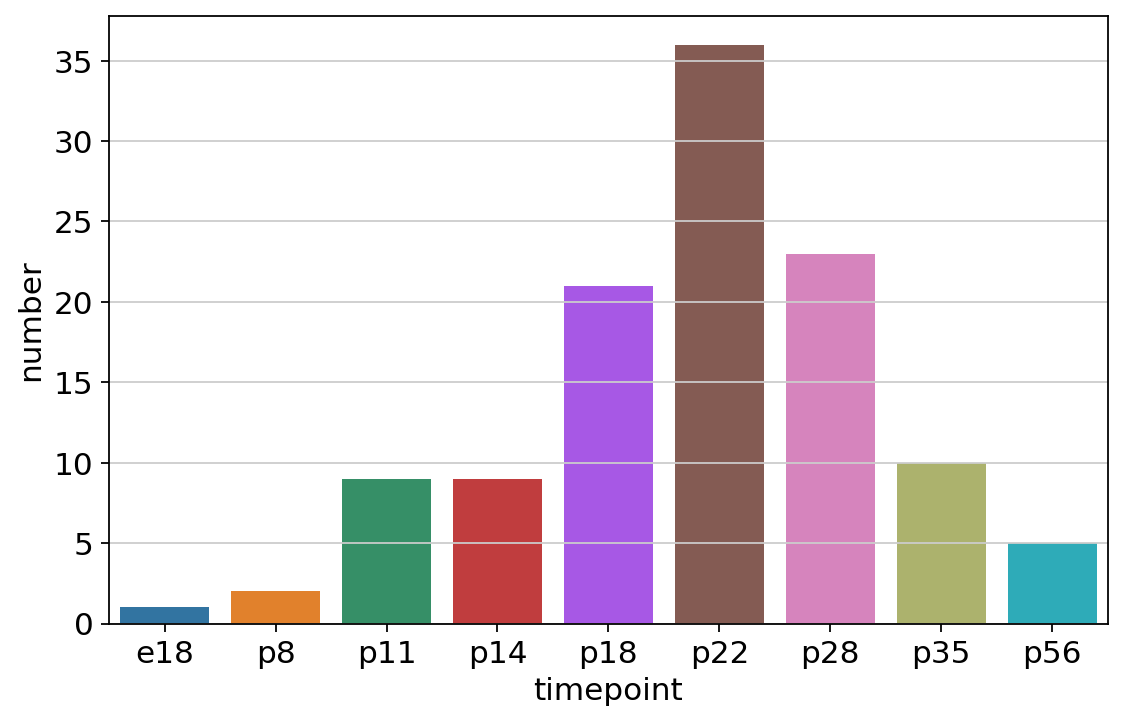

In [136]:
plt.figure(figsize=(8, 5))
myfig = plt.gcf()
sns.barplot(x="timepoint", y="number", data=result)
myfig.savefig("number")